# Binary Text Classification on Steam Game Reviews

Link to Dataset: https://www.kaggle.com/arashnic/game-review-dataset/code

Direct Link to CSV file: https://drive.google.com/file/d/1_CbwYD8TLDcJsGp3ZFh-YOwypYxJ5T-K/view?usp=sharing

# Libraries

In [1]:
import time, os

import numpy as np # linear algebra
import pandas as pd # data processing
pd.set_option('display.max_colwidth', -1) # display the entire contents of each cell

import seaborn as sns # visualization
import matplotlib.pyplot as plt
%matplotlib inline

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Text Importation and Preview

Method 1


In [ ]:
#Intructions for importing the dataset
#download steam_reviews.csv from the direct link from kcho12's google drive or use file included in blackboard
#Choose file "steam_reviews.csv"
from google.colab import files
uploaded = files.upload()

In [ ]:
review_data = pd.read_csv('steam_reviews.csv') 
review_data.shape, display(review_data.head())

Method 2

In [2]:
#Intructions for importing the dataset
#download steam_reviews.csv from the direct link from kcho12's google drive use file included in blackboard
#click on folder on left sidebar
#click "upload to session storage" button and choose the steam_reviews.csv

##review_data = pd.read_csv('/content/drive/MyDrive/steam_reviews.csv')
review_data = pd.read_csv('steam_reviews.csv') 
review_data.shape, display(review_data.head())

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,"I'm scared and hearing creepy voices. So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times. This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean'). Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd. I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.",Yes
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bored.Cons:Buying pants/briefs. You haven't downloaded it yet.",Yes
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you know how to play, very easy to master. I've made it to floor 1000 before, but due to certain circumstances was unable to finish. Was not game related, don't worry, not a bug/glitch or antyhing.I highly recommend this for casual play, maybe with a friend or two watching. Hilarity ensues, especially once you hit floor 150. Have fun my fellow fleshlings!",Yes
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!",Yes
4,5,Spooky's Jump Scare Mansion,2015.0,"Not many games have the cute tag right next to the horror tag on Steam.I first played this game in late 2014 and coming back to it for the first time since. This game is so good for it being free, take advantage and experience it. Try and get to room 1000 or as close as you can. The further you progress the darker the game becomes.",Yes


((17494, 5), None)

In [3]:
#Removing duplicates
review_data = review_data.drop_duplicates(keep="first")
review_data.shape

(17494, 5)

In [4]:
# check empty cells
review_data.isnull().sum()

review_id          0  
title              0  
year               178
user_review        0  
user_suggestion    0  
dtype: int64

No Duplicates were found in Data. We have around 17,500 reviews to analyze. The empty cells in year have no impact on our sentiment analysis.

In [5]:
review_data['length'] = review_data['user_review'].apply(len) # number of characters
review_data['length'].describe() # info()
# the describe function shows the mean, std, min, max of length of the reviews

count    17494.000000
mean     760.905167  
std      902.864197  
min      6.000000    
25%      274.000000  
50%      449.000000  
75%      851.000000  
max      8000.000000 
Name: length, dtype: float64

Average review length is 760 characters.
Smallest review is 6 characters. Longest Review is 8000 Characters.

In [6]:
#Checking amount of Positive and Negative Reviews
review_data.user_suggestion.value_counts()

Yes    9968
No     7526
Name: user_suggestion, dtype: int64

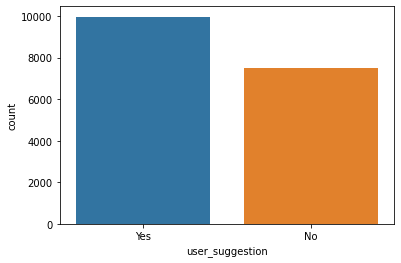

In [7]:
#show bar graph of positive vs negative reviews
sns.countplot(review_data["user_suggestion"])

Dataset is slightly imbalanced in favor of positive reviews, but its not horrible as long as we shuffle the dataset.

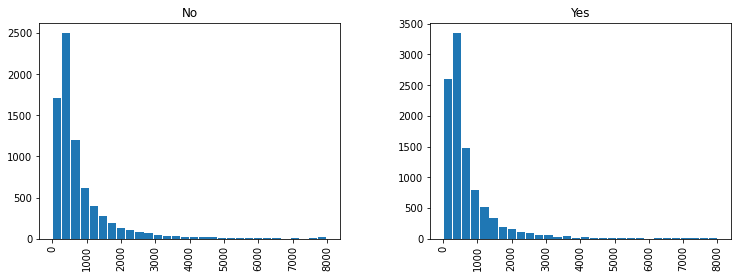

In [8]:
#show character length of negative and positive reviews
review_data.hist(column='length', by='user_suggestion',bins=30, figsize=(12,4),rwidth=0.9)
plt.show()

Length does not have any impact on a positive or negative review.

# Pre-Processing

In [9]:
review_data.user_review[3000]
#An example review data
#We need to get rid of numbers, contracted phrases, urls, non-alphabet letters, and stopwards.

"At it current state(1.81) is to expensive to play the game, if you don't have premium account you can't progress at all because of the repair cost and even if you do have you can't make mistakes if you want to have enough Silver Lions to buy another vehicle, stock vehicle are the worst, planes isn't that much but you still can feel a difference, the big problem here are mainly tanks were if you don't have repairs and FPE(extinguisher) you are useless if they get any of the parts of the tank unless you get to the capture point to repair (if they get your engine you can't do anything), matchmaking is too compressed so sometimes you get games where your tank or your plane lacks too much compared to others and still with the compression  takes some time to get into battle depending on your Rank(if you don't get a small game with 6-8 people, wich are decided on the first 3min of the game), this game have become a P2W or even worst than that because at it current state premium isn't helping

In [10]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"haven\'t", "have not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

#lecture 10 pre-processing
def stopword_remove(phrase):
    #Exluding NO, NOR, NOT from the stop words as they play keyrole
    stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
              'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
              'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
              'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
              'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
              'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
              'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
              'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
              'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
              's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
              've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
              "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
              "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
              'won', "won't", 'wouldn', "wouldn't"])
    tokens = word_tokenize(phrase)
    nonstop_token_list = [word for word in tokens if not word in stopwords] 
    phrase = TreebankWordDetokenizer().detokenize(nonstop_token_list)

    return phrase

In [11]:
def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['user_review']):

        #lowercase words if they haven't been yet
        review_text = str.lower(review_text)
        
        # expand the contracted words
        review_text = decontracted(review_text)

        #remove stopwords
        review_text = stopword_remove(review_text)
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)

        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])

        #remove url 
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)

        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review

review_data['cleaned_review'] = clean_text(review_data)
# review_data['cleaned_review'] = review_data.apply(clean_text)
review_data = review_data.drop(columns=['review_id','title','year'])

review_data.head()
# After the cleaning process, we get the cleaned_reviews

100%|██████████| 17494/17494 [00:34<00:00, 511.58it/s]


,user_review,user_suggestion,length,cleaned_review
0,"I'm scared and hearing creepy voices. So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times. This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean'). Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd. I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.",Yes,710,scared hearing creepy voices pause moment write review wait heart beat return atleast somewhat calmer times game adorable creepy like happy tree friends graphics sceme childhood bubble clean hello is what charactes isnot trying kill likable bit odd noob things though oh look class room full ghosts dead children lets shine flashlight stand staring them or hmm creepy music turn around see see chasing me never game afraid finding locked door
1,"Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bored.Cons:Buying pants/briefs. You haven't downloaded it yet.",Yes,335,best game better sam pepper youtube account what need play computersome extra pants pros scary hell fun adventure spooky did forgot mention scary hell get pants briefs wardrobe time consuming bored cons buying pants briefs not downloaded yet
2,"A littly iffy on the controls, but once you know how to play, very easy to master. I've made it to floor 1000 before, but due to certain circumstances was unable to finish. Was not game related, don't worry, not a bug/glitch or antyhing.I highly recommend this for casual play, maybe with a friend or two watching. Hilarity ensues, especially once you hit floor 150. Have fun my fellow fleshlings!",Yes,397,littly iffy controls know play easy master made floor due certain circumstances unable finish not game related not worry not bug glitch antyhing i highly recommend casual play maybe friend two watching hilarity ensues especially hit floor fun fellow fleshlings
3,"Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!",Yes,280,great game fun colorful that a side note though getting windowed mode computer hates fullscreen yeah computer not like run shame really enjoyable guess settle skyrim cheers
4,"Not many games have the cute tag right next to the horror tag on Steam.I first played this game in late 2014 and coming back to it for the first time since. This game is so good for it being free, take advantage and experience it. Try and get to room 1000 or as close as you can. The further you progress the darker the game becomes.",Yes,334,not many games cute tag right next horror tag steam i first played game late coming back first time since game good free take advantage experience try get room close progress darker game becomes


Next, I apply the binary labels and we will be ready for Features.

In [13]:
#binary labels are applied and now we can train a classifier
review_data['label'] = review_data['user_suggestion'].map({'Yes':1,'No':0})
review_data.head()[['cleaned_review','user_suggestion','label']]

,cleaned_review,user_suggestion,label
0,scared hearing creepy voices pause moment write review wait heart beat return atleast somewhat calmer times game adorable creepy like happy tree friends graphics sceme childhood bubble clean hello is what charactes isnot trying kill likable bit odd noob things though oh look class room full ghosts dead children lets shine flashlight stand staring them or hmm creepy music turn around see see chasing me never game afraid finding locked door,Yes,1
1,best game better sam pepper youtube account what need play computersome extra pants pros scary hell fun adventure spooky did forgot mention scary hell get pants briefs wardrobe time consuming bored cons buying pants briefs not downloaded yet,Yes,1
2,littly iffy controls know play easy master made floor due certain circumstances unable finish not game related not worry not bug glitch antyhing i highly recommend casual play maybe friend two watching hilarity ensues especially hit floor fun fellow fleshlings,Yes,1
3,great game fun colorful that a side note though getting windowed mode computer hates fullscreen yeah computer not like run shame really enjoyable guess settle skyrim cheers,Yes,1
4,not many games cute tag right next horror tag steam i first played game late coming back first time since game good free take advantage experience try get room close progress darker game becomes,Yes,1


# Text Features


## Parameter Tuning: Grid search

I did parameter tuning first because it made the most sense for me to check out what parameters worked best before doing feature engineering.

I orignally used ngram_range = (1,1) before improving my performance by swapping to ngram(1,2).

In [14]:
#This grid search takes 700 seconds or 11 minutes so I will just screenshot the results for ngram_range(1,1) and (1,2)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(lowercase=True, stop_words=('early', 'access', 'is'), ngram_range=(1,1)) #change to ngram_range(1,2) if you want to see its output
logistic = LogisticRegression() # , tol=0.1

# build a pipeline
pipe = Pipeline(steps = [
       ('vectorizer', vectorizer),
       ('classifier', logistic)])

# creat a dictionary of model parameters and corresponding values
# For example, in countvectorizer, we want to explore the suitable value for min_df, select from 1,3,5,10
param_grid = {
    'vectorizer__min_df': [10, 15, 20, 0.05],
    'vectorizer__max_df': [0.6, 0.7, 0.8],
    'classifier__penalty': ['l1','l2']}

# run GridSearchCV, cv, f1
search_result = GridSearchCV(pipe, param_grid, cv=5, scoring='f1').fit(review_data.cleaned_review.values, review_data.label.values)


print("Best parameter (CV score=%0.3f):" % search_result.best_score_) # scoring: accuracy by default
print(search_result.best_params_)
# with 5 fold cv, the best f1 score is 0.784, and the corresponding parameter values are as follows:

Best parameter (CV score=0.784):
{'classifier__penalty': 'l2', 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 10}


Results for ngram_range(1,1)

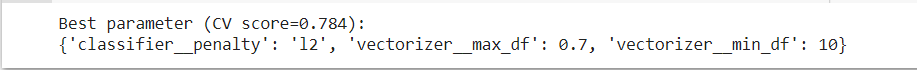

Result for ngram_range=(1,2)

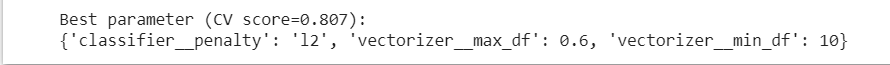

Since ngram_range(1,2) has a higher CV score than ngram_range(1,1), I only will show a preview of the features for ngram_range(1,2)

## Feature Engineering

In [15]:
#Count vectorizer for bag of words and 2-gram features
vectorizer = CountVectorizer(lowercase=True, stop_words=('early', 'access', 'is'), max_df=0.6, min_df=10, ngram_range=(1,2)) ##early access is not part of the review it just means the game is in early access
X = vectorizer.fit_transform(review_data['cleaned_review'])
y = review_data.label.values

#I will also include the count vectorizer for 1-gram features for performance comparison
vectorizer2 = CountVectorizer(lowercase=True, stop_words=('early', 'access', 'is'), max_df=0.7, min_df=10, ngram_range=(1,1))
X2 = vectorizer2.fit_transform(review_data['cleaned_review'])

print(X.toarray())
print("X.shape : ",X.shape)
print("y.shape : ",y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
X.shape :  (17494, 18039)
y.shape :  (17494,)


With my current parameters "CountVectorizer(lowercase=True, stop_words=('early', 'access', 'is'), max_df=0.6, min_df=10, ngram_range=(1,2))", my feature list is 18,039.

In [16]:
print(vectorizer.get_feature_names())

['aa', 'aaa', 'aaa game', 'aaa title', 'ab', 'abandon', 'abandoned', 'abilites', 'abilities', 'abilities not', 'abilities weapons', 'ability', 'ability play', 'ability use', 'abit', 'able', 'able build', 'able buy', 'able compete', 'able enjoy', 'able find', 'able fly', 'able get', 'able hunt', 'able join', 'able keep', 'able make', 'able play', 'able run', 'able see', 'able take', 'able unlock', 'able use', 'abomination', 'about', 'above', 'abrams', 'absolute', 'absolute garbage', 'absolute trash', 'absolute worst', 'absolutely', 'absolutely amazing', 'absolutely fantastic', 'absolutely love', 'absolutely no', 'absolutely not', 'absolutely nothing', 'absolutely terrible', 'absolutly', 'absurd', 'absurdly', 'abundance', 'abuse', 'abused', 'abusing', 'abusive', 'abysmal', 'ac', 'acc', 'accept', 'acceptable', 'accepted', 'accepting', 'acces', 'accessed', 'accessibility', 'accessible', 'accessories', 'accident', 'accidentally', 'accidently', 'accomplish', 'accomplished', 'accomplishing', 

In [17]:
vectorizer.vocabulary_

{'scared': 14125,
 'hearing': 7300,
 'creepy': 2808,
 'voices': 17098,
 'pause': 11675,
 'moment': 9981,
 'write': 17886,
 'review': 13612,
 'wait': 17120,
 'heart': 7301,
 'beat': 1125,
 'return': 13599,
 'atleast': 829,
 'somewhat': 14859,
 'times': 16335,
 'adorable': 219,
 'like': 8669,
 'happy': 7209,
 'tree': 16521,
 'friends': 5103,
 'graphics': 6957,
 'childhood': 2075,
 'clean': 2146,
 'hello': 7339,
 'what': 17478,
 'trying': 16615,
 'kill': 8267,
 'bit': 1344,
 'odd': 11185,
 'noob': 10658,
 'things': 16002,
 'though': 16099,
 'oh': 11217,
 'look': 9022,
 'class': 2124,
 'room': 13905,
 'full': 5155,
 'ghosts': 6573,
 'dead': 2988,
 'children': 2077,
 'lets': 8600,
 'shine': 14424,
 'flashlight': 4838,
 'stand': 15094,
 'staring': 15108,
 'them': 15944,
 'or': 11450,
 'hmm': 7458,
 'music': 10230,
 'turn': 16638,
 'around': 731,
 'see': 14223,
 'chasing': 2043,
 'me': 9625,
 'never': 10382,
 'afraid': 263,
 'finding': 4717,
 'locked': 8970,
 'door': 3532,
 'write review': 17

## Train Test split

In [19]:
train_idx, test_idx = train_test_split(np.arange(review_data.shape[0]), test_size=0.3, shuffle=True, random_state=78)

len(train_idx), len(test_idx)
print("Number of training examples:{}".format(len(train_idx)))
print("Number of testing examples:{}".format(len(test_idx)))

Number of training examples:12245
Number of testing examples:5249


I have a 30% test size to 70% training size which gives me 12,245 training samples and 5249 testing samples.

In [20]:
#training data is put into tables for model training
X_train = X[train_idx]
X2_train = X2[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
X2_test = X2[test_idx]
y_test = y[test_idx]

print("Training data: X_train : {}, y_train : {}".format(X_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(X_test.shape, y_test.shape))

Training data: X_train : (12245, 18039), y_train : (12245,)
Testing data: X_test : (5249, 18039), y_test : (5249,)


## Classifier: Logistic Regression

In [21]:
# fit a logistic regression classifier on the training data use default settings
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_clf2 = LogisticRegression()
lr_clf2.fit(X2_train, y_train)

# make prediction on testing data
y_pred_test = lr_clf.predict(X_test)
y_predprob_test = lr_clf.predict_proba(X_test)
y2_pred_test = lr_clf2.predict(X2_test)
y2_predprob_test = lr_clf2.predict_proba(X2_test)

# Evaluation

## Precision, Recall, and F1-Score for ngram(1,1)

In [24]:
print(classification_report(y_test, y2_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      2249
           1       0.86      0.87      0.86      3000

    accuracy                           0.84      5249
   macro avg       0.84      0.84      0.84      5249
weighted avg       0.84      0.84      0.84      5249



## Precision, Recall, and F1-Score for ngram(1,2)

In [25]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      2249
           1       0.87      0.89      0.88      3000

    accuracy                           0.86      5249
   macro avg       0.86      0.86      0.86      5249
weighted avg       0.86      0.86      0.86      5249



As we can see here, there is improvement over using ngram(1,2) rather than ngram(1,1). The rest of the sections in this notebook will only be looking at ngram(1,2) testing parameters.

## Cross Validation

In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_clf, X, y, cv=5, scoring='precision')
print(scores)

[0.80009407 0.82235108 0.77505882 0.82988248 0.8380903 ]


## ROC Curve

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_predprob_test[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

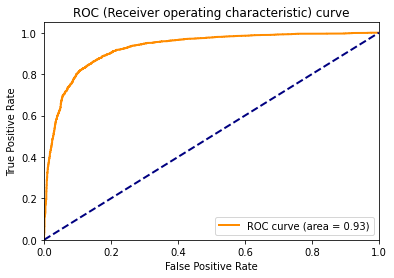

In [28]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

## Precision Recall Curve

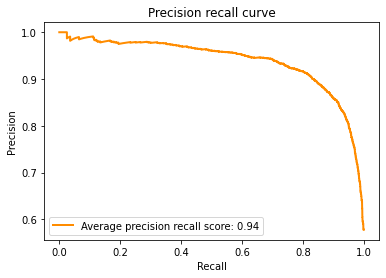

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_predprob_test[:,1], pos_label=1)

plt.plot(recall, precision, color='darkorange', lw=lw, label='Average precision recall score: %0.2f' % average_precision_score(y_test, y_predprob_test[:,1]))

plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Interpretation

## Top Positive Features

In [30]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('fantastic', 1.377),
 ('addictive', 1.367),
 ('not pay', 1.25),
 ('scared', 1.243),
 ('definitely', 1.192),
 ('ign', 1.17),
 ('addicted', 1.165),
 ('ccg', 1.141),
 ('rewarding', 1.138),
 ('alpha', 1.134)]

As we can see here, the top positive features are words such as fantastic, addictive, and not-pay which makes sense for positive reccomendations.

## Top Negative Features

In [31]:
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('not recommend', -2.775),
 ('not worth', -2.21),
 ('worst', -1.842),
 ('ruined', -1.628),
 ('poor', -1.524),
 ('terrible', -1.521),
 ('wtf', -1.49),
 ('gaijin', -1.401),
 ('sad', -1.348),
 ('ridiculous', -1.339)]

For negative reviews, the top negative feature is the reason why I included bi-grams because not and recommend can mean two complete different sentiments if they are separate. The other features also make sense for negative reviews.

## Mislabled Review Analysis

In [32]:
#sets review_data to test_idx so we can see what reviews are being tested
review_data_test = review_data
review_data_test = review_data_test.iloc[test_idx]

In [33]:
#A look at the mislabeled reviews
review_data_test['pred_label'] = y_pred_test
review_data_test.head(3)[['user_review','label','pred_label']]
review_data_test[review_data_test['label'] != review_data_test['pred_label']].head()[['user_review','label','pred_label']]

,user_review,label,pred_label
11626,Early Access Reviewonly played a few min of this game and they need work on it and a hack shield if they dont get one hackers will ruin the game other than that it was fun and ill continue to play this maybe they will advance it futher,1,0
11836,"Feels and plays like an old game.Combat feels weird and autopath is even weirder.Performances are pretty bad even on high end machines.Game map is huge but the world feels so empty and dull.Can't believe people really paid to enter EA and beta test this game.Plenty of better MMORPG out there, this is below average at best.",0,1
15722,"Early Access ReviewAfter giving this game a pretty serious bit of time over the last month I have to sadly give it a thumbs down as a PC game. Now as for on mobile devices Id say its standard play with a solid art style. But for those of us on PCs here on steam as maybe a pure ftp game its an ok casual time waster.However the game is thick with micro transactions. It costs to skip many hour long( sometimes day long) crafting times.It costs for many cosmetic rewards you still have to first earn the right to use via game play. Now the company wanting money is not some sin. But consider this. for the ultimate guardian pack they want 50 bucks. You get a few unique cosmetics, some extra storage a butt load of their dragon crystal points that still wont get you more then a few of the pricier point only in game items.Now consider a classic but high quality pay once play forever fully finished MMO like Guild Wars. for 30 bucks you get the classic campaign trilolgy and for another 20 the eye of the north expansion. While old GW is far from dated. the graphics are still eye catchingly lovely, and easily destroy the cartoon style of this game. Game play wise, sure GW does especially during its lowbie levels use common collect and fetch quest systems, but also has rich virbant stories, and many quests that demand the use of ones brain or at least reading the comprehensive wiki to develop winning strategies.While I can see dabbling in this game from time to time, and using it as a chat room game, the moment I start thinking of spending a cent it loses out to many other games. Many of which I can get many hours of play in for a much more modest price.Sadly this company seems more about drawing in a fan base that they can sell silly RL merchendise like shirts, novelty hats, and primitive physical calenders all with in game cosmetic items as part of the deal, to make their money. It feels like they are wasting alot of their development energy on limited time events, exclusive cosmetics that require buying some item that will act as free advertisment for them, and very little really spent on content or QoL improvments.So while if I could Id rate it as an ok entry into mobile games, for steam pc gamers we just have too many better options to waste time or risk money on an EAG that shows little real potential to rival even old pc MMO like classic Guild Wars.Soif your looking for a pure FTP with no intent to spend then sure give it some time waster hours, otherwise invest your time and especially your money in something worthy of it.",0,1
10076,"I dont get it why peopel are always â™¥â™¥â™¥â™¥â™¥ing about you need to have alicense for evrythingSure you need memebership, to enjoy evrything, but 3 months of membership is not thate xpensive.These days evrybody want evrything for free.And with teh changes made for the free part of teh game, the animals are now on a rotating base.So if you have patiance you can have a crack at evry animal, also with teh basic items you get you can shoot evryanimal. that is in teh rotation, so no you dont have to buy all weapons.This game has been around for many years, if it is so bad as most reviuw writers say.Why does it have so many members, me included, if its that bad ?peopel complaining after only playing 10 minutes, is just bad, give teh game a chance.I definatly have my fun from it and i enjoy it very 

In [35]:
#cleaned review versions of mislabeled reviews
review_data_test.head(3)[['cleaned_review','label','pred_label']]
review_data_test[review_data_test['label'] != review_data_test['pred_label']].head()[['cleaned_review','label','pred_label']]

,cleaned_review,label,pred_label
11626,early access reviewonly played min game need work hack shield dont get one hackers ruin game fun ill continue play maybe advance futher,1,0
11836,feels plays like old game combat feels weird autopath even weirder performances pretty bad even high end machines game map huge world feels empty dull cannot believe people really paid enter ea beta test game plenty better mmorpg average best,0,1
15722,early access reviewafter giving game pretty serious bit time last month sadly give thumbs pc game mobile devices id say standard play solid art style us pcs steam maybe pure ftp game ok casual time waster however game thick micro transactions costs skip many hour long sometimes day long crafting times it costs many cosmetic rewards still first earn right use via game play company wanting money not sin consider ultimate guardian pack want bucks get unique cosmetics extra storage butt load dragon crystal points still wont get pricier point game items now consider classic high quality pay play forever fully finished mmo like guild wars bucks get classic campaign trilolgy another eye north expansion old gw far dated graphics still eye catchingly lovely easily destroy cartoon style game game play wise sure gw especially lowbie levels use common collect fetch quest systems also rich virbant stories many quests demand use ones brain least reading comprehensive wiki develop winning strategies while see dabbling game time time using chat room game moment start thinking spending cent loses many games many get many hours play much modest price sadly company seems drawing fan base sell silly rl merchendise like shirts novelty hats primitive physical calenders game cosmetic items part deal make money feels like wasting alot development energy limited time events exclusive cosmetics require buying item act free advertisment little really spent content qol improvments so could id rate ok entry mobile games steam pc gamers many better options waste time risk money eag shows little real potential rival even old pc mmo like classic guild wars soif looking pure ftp no intent spend sure give time waster hours otherwise invest time especially money something worthy,0,1
10076,dont get peopel always ing need alicense evrythingsure need memebership enjoy evrything months membership not thate xpensive these days evrybody want evrything free and teh changes made free part teh game animals rotating base so patiance crack evry animal also teh basic items get shoot evryanimal teh rotation no dont buy weapons this game around many years bad reviuw writers say why many members included bad peopel complaining playing minutes bad give teh game chance i definatly fun enjoy much,1,0
13277,modes autoplayed computer serious flaws like seriously computer no idea seen monster go back kill summoned totem insead attacking monster also rambo always uses ultimate monster lowest hp insted attacking grouped monsters monster attacking summonmed units priority instead killing another monster serious problems opinion tactical monsters yet no tactic computer gameplay,1,0


## Properly Labeled Reviews

In [36]:
#A look at the matched reviews
review_data_test.head(4)[['user_review','label','pred_label']]

,user_review,label,pred_label
15282,The game starts of with no♥♥♥♥♥blasting music of the headset like most games and it was fun to play arround in with a friend simple but well executed. Quick download to play monopoloy with your friends.Seems like it could be pay 2 win but didn't investigate further.,1,1
16945,"Early Access ReviewBest Game in the World! What can I say? Fornite is garbage town, PUBG is two fps town, this mixsgood graphics, with cars, epic guns, and ♥♥♥♥ING PANS, this has to bethe best god damn game I have ever played, like no joke I got 80 hours on this beast, and now they got cooking seasons? What is next? Runs great, plays great, feels great. Keep up all the amazing working!!!",1,1
7085,"I love the game. Long time player of both MTG and the Elder Scrolls game all the way back to Daggerfall, and this is a perfect combination of two of my favorite games. I'm not what I would call a 'serious player', but I do enjoy coming up with on-the-fly decks to meet daily rewards, the draft (arena) system, and trying to crawl my way up the ladder.I enjoyed Hearthstone, may or may not go back from time to time, this one is more up my alley, and as far as I'm concerned it's more challenging of a card game.Toxic Players: not concerned about them. You can mute their avatar if they don't shut up and the turn timer counts down pretty quick once a turn of inactivity passes in case they just want to sit and run the timer out. I love the art, especially the alternate art on some of the cards. Some of the premiums are beautiful.",1,1
12852,"Yes I do Recommend the game in all especially for mobile since there is no Fallout 4 and etc on there but I do recommend this game its a free fun copy of fallout but more of an overseers Point of view its jsut the Problem everyoen keeps issueing that the Stats goes down to quickly and I personally agree Wait like 3-10 minutes your food bar or water bar your stats would go down very quickly and making your dwellers would be unsatisfied we would allpretty much get pissy and stuff so Personnaly to me to Bethasda Please Enhance the time for the Stats, Thank you for Reading.",1,1


## Conclusions
I think my classifier performed well since the classification report gave scores all above .80 for precision, recall, and F1. If I had a bigger dataset with more varied games then I may have better results because my test sample was kinda small (5000 samples), and just having more samples in general means a bigger training set and test set.


For parameter tuning and improvement I had performance increase of 2.2%. I originally used ngram(1,1) which gave me around 7500 features to use in the analysis, but later I swapped to ngram(1,2) after noticing that some of the top features for ngram(1,1) didn't make sense like "complaint" and "complaining". Some bi-grams such as "not recommend" can drastically change the sentiment of a review if you only view it as "not" and "recommend", so I thought it was important to retain bi-grams such as that to retain accuracy. 

For mismatched reviews, the classifier had trouble with reviews that stated many negative things about a game, but a had reviewer still wanting to play it despite those flaws. Reviews that compared a game to another game also confused the classifier since the reviewer would start describing a different game than the one they were reviewing.